# ALGORITMO K MODES

KModes es una alternativa al algoritmo KMeans para aquellos conjuntos de datos cuyas variables son mayoritariamente categóricas, como es el caso de este conjunto 

In [64]:
import pickle

import pandas as pd
import numpy as np
import random

# !pip install kmodes

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
adoptados= pd.read_csv("./poblacion_adoptados_v3.csv")

NameError: name 'pd' is not defined

In [66]:
adoptados

,id_animal,id_centro,Raza,Especie,Sexo,Tamaño,Microchip,Tiempo,Edad
0,1,543,Mestizo,Canina,Hembra,Mediano,False,0 año y 3 meses,3 años y 1 mes
1,2,118,Mestizo,Canina,Macho,Pequeño,True,0 año y 2 meses,3 años y 7 meses
2,3,757,Mestizo,Canina,Hembra,Pequeño,True,0 año y 0 mes,11 años y 6 meses
3,4,609,Pastor Belga,Canina,Hembra,Mediano,False,0 año y 4 meses,1 año y 0 mes
4,5,743,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,3 años y 10 meses
...,...,...,...,...,...,...,...,...,...
499995,499996,756,Mestizo,Canina,Macho,Mediano,True,0 año y 0 mes,9 años y 2 meses
499996,499997,156,Mestizo,Canina,Hembra,Mediano,True,1 año y 3 meses,2 años y 7 meses
499997,499998,132,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,9 años y 9 meses
499998,499999,826,Mestizo,Canina,Macho,Mediano,True,1 año y 6 meses,10 años y 10 meses


##### 1. TRANSOFRMACIÓN LABEL ENCODER/ ORDINAL ENCODER

Antes de aplicar la transformación, es mejor que parsee las variables tiempo y edad a numéricas

In [67]:
import re

In [68]:
def parse_age(age_str):
    match = re.search(r'(\d+) años? (y (\d+) meses?)?', age_str)
    if match:
        years_str = match.group(1)
        years = int(years_str) if years_str else 0
        months_str = match.group(3)
        months = int(months_str) if months_str else 0
        total_months = years * 12 + months
        return total_months / 12
    else:
        return None

In [69]:
adoptados['Tiempo_parseado'] = adoptados['Tiempo'].apply(parse_age)
adoptados['Edad_parseado'] = adoptados['Edad'].apply(parse_age)

In [70]:
adoptados

,id_animal,id_centro,Raza,Especie,Sexo,Tamaño,Microchip,Tiempo,Edad,Tiempo_parseado,Edad_parseado
0,1,543,Mestizo,Canina,Hembra,Mediano,False,0 año y 3 meses,3 años y 1 mes,0.250000,3.000000
1,2,118,Mestizo,Canina,Macho,Pequeño,True,0 año y 2 meses,3 años y 7 meses,0.166667,3.583333
2,3,757,Mestizo,Canina,Hembra,Pequeño,True,0 año y 0 mes,11 años y 6 meses,0.000000,11.500000
3,4,609,Pastor Belga,Canina,Hembra,Mediano,False,0 año y 4 meses,1 año y 0 mes,0.333333,1.000000
4,5,743,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,3 años y 10 meses,0.000000,3.833333
...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,756,Mestizo,Canina,Macho,Mediano,True,0 año y 0 mes,9 años y 2 meses,0.000000,9.166667
499996,499997,156,Mestizo,Canina,Hembra,Mediano,True,1 año y 3 meses,2 años y 7 meses,1.250000,2.583333
499997,499998,132,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,9 años y 9 meses,0.000000,9.750000
499998,499999,826,Mestizo,Canina,Macho,Mediano,True,1 año y 6 meses,10 años y 10 meses,1.500000,10.833333


Selecciono las columnas que quiero pasar por el **encoder** del tipo que sea

In [71]:
adoptados.columns

Index(['id_animal', 'id_centro', 'Raza', 'Especie', 'Sexo', 'Tamaño',
       'Microchip', 'Tiempo', 'Edad', 'Tiempo_parseado', 'Edad_parseado'],
      dtype='object')

Selecciono una muestra de los datos para que no tarde tanto en entrenarse el modelo:

In [74]:
muestra = adoptados.sample(n=200000)

In [75]:
variables = muestra[['Raza', 'Especie', 'Sexo', 'Tamaño','Microchip', 'Tiempo_parseado', 'Edad_parseado']]

Preparación de los datos utilizando **label encoder**, que permite transformar variables categoricas en numéricas y por otro lado **order encoder**, qur permite transformar variables con orden natural como la edad y el tiempo

In [76]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Definir las columnas a codificar con LabelEncoder y OrdinalEncoder
label_cols = ['Raza', 'Especie', 'Sexo', 'Tamaño', 'Microchip']
ordinal_cols = ['Tiempo_parseado', 'Edad_parseado']

# Crear los objetos encoder
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()

# Aplicar LabelEncoder a las columnas seleccionadas
variables[label_cols] = variables[label_cols].apply(label_encoder.fit_transform)

# Aplicar OrdinalEncoder a las columnas seleccionadas
variables[ordinal_cols] = ordinal_encoder.fit_transform(variables[ordinal_cols])

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13556\4026984103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables[label_cols] = variables[label_cols].apply(label_encoder.fit_transform)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13556\4026984103.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables[ordinal_cols] = ordinal_encoder.fit_transform(variables[ordinal_cols])


Ahora el dataframe "variables" será el codificado

##### 2. SELECCIÓN DEL NÚMERO ÓPTIMO DE CLÚSTERS

**a. SILUETA**

In [77]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    km_huang = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
    km_huang.fit_predict(variables)
    cluster_labels = km_huang.labels_
    silhouette_avg = silhouette_score(variables, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.0012959632569455347
For n_clusters = 3 The average silhouette_score is : -0.006201744702838457
For n_clusters = 4 The average silhouette_score is : -0.29080071686424397
For n_clusters = 5 The average silhouette_score is : -0.015072721253393725
For n_clusters = 6 The average silhouette_score is : -0.026469436949136158
For n_clusters = 7 The average silhouette_score is : -0.019316252280553094
For n_clusters = 8 The average silhouette_score is : -0.032823704230264594
For n_clusters = 9 The average silhouette_score is : -0.29427569883423454
For n_clusters = 10 The average silhouette_score is : -0.07681604338093072


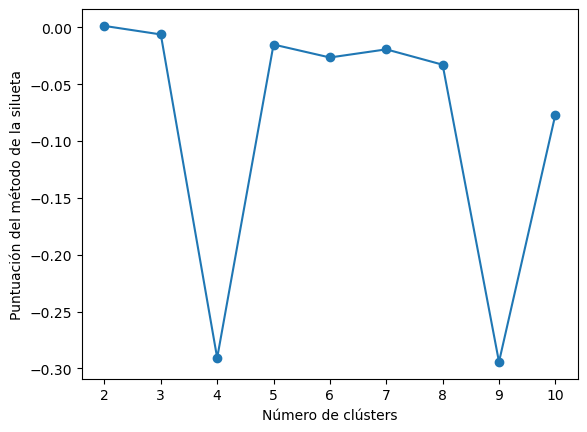

In [79]:
silhouette_scores= [0.0012959632569455347, -0.006201744702838457, -0.29080071686424397,
                   -0.015072721253393725,-0.026469436949136158, -0.019316252280553094,
                   -0.032823704230264594, -0.29427569883423454, -0.07681604338093072]
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de clústers')
plt.ylabel('Puntuación del método de la silueta')
plt.show()

**b. CODO**

Recorto un poco más la muestra para que no tarde tanto

In [82]:
variables1 = variables.sample(n=50000)

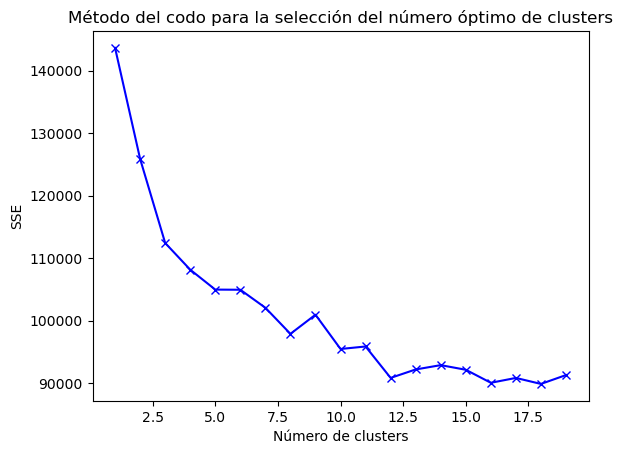

In [83]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import numpy as np

# Rango de número de clusters que se van a probar
num_clusters = range(1, 20)

# Almacenar los resultados de la suma de distancias cuadradas dentro del grupo para cada valor de k
sse = []
for k in num_clusters:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(variables1)
    sse.append(km.cost_)

# Graficar la curva del método del codo
plt.plot(num_clusters, sse, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del codo para la selección del número óptimo de clusters')
plt.show()


##### 3. SELECCIÓN DEL TIPO DE INICIALIZACIÓN

In [86]:
# Definir diferentes tipos de inicialización
init_types = ['Huang', 'Cao', 'random']

# Lista para guardar el valor de cost para cada tipo de inicialización
costs = []

# Calcular el valor de cost para cada tipo de inicialización
for init_type in init_types:
    km = KModes(n_clusters=8, init=init_type, n_init=10, verbose=0)
    km.fit(variables)
    costs.append(km.cost_)

# Seleccionar el tipo de inicialización con el valor de cost más bajo
best_init_idx = np.argmin(costs)
best_init_type = init_types[best_init_idx]

print("El mejor tipo de inicialización es:", best_init_type, ",todos los valores son: ", costs)


El mejor tipo de inicialización es: Huang ,todos los valores son:  [393791.0, 418029.0, 402490.0]


##### 4. ENTRENAMIENTO DEL MODELO

In [87]:
km = KModes(n_clusters=8, init='Huang', n_init=10, verbose=0)
clusters = kmode.fit_predict(variables)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20768, cost: 405777.0


##### 5. UNIÓN DE LA COLUMNA CLUSTER AL CONJUNTO DE DATOS

In [89]:
muestra

,id_animal,id_centro,Raza,Especie,Sexo,Tamaño,Microchip,Tiempo,Edad,Tiempo_parseado,Edad_parseado
297265,297266,17,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,6 años y 6 meses,0.000000,6.500000
188571,188572,747,Mestizo,Canina,Hembra,Mediano,True,1 año y 0 mes,14 años y 0 mes,1.000000,14.000000
496996,496997,836,Gato,Felina,Macho,Pequeño,True,0 año y 4 meses,8 años y 2 meses,0.333333,8.166667
33448,33449,779,Podenco,Canina,Macho,Grande,True,1 año y 10 meses,9 años y 3 meses,1.833333,9.250000
335030,335031,815,Podenco,Canina,Macho,Mediano,True,0 año y 4 meses,1 año y 3 meses,0.333333,1.250000
...,...,...,...,...,...,...,...,...,...,...,...
100237,100238,827,Spaniel,Canina,Macho,Pequeño,True,0 año y 0 mes,8 años y 4 meses,0.000000,8.333333
99827,99828,441,Mestizo,Canina,Macho,Mediano,True,0 año y 0 mes,1 año y 8 meses,0.000000,1.666667
301333,301334,110,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,13 años y 6 meses,0.000000,13.500000
372568,372569,35,Mestizo,Canina,Hembra,Grande,True,0 año y 2 meses,12 años y 10 meses,0.166667,12.833333


In [90]:
muestra.insert(0, "Cluster", clusters, True)
muestra

,Cluster,id_animal,id_centro,Raza,Especie,Sexo,Tamaño,Microchip,Tiempo,Edad,Tiempo_parseado,Edad_parseado
297265,0,297266,17,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,6 años y 6 meses,0.000000,6.500000
188571,7,188572,747,Mestizo,Canina,Hembra,Mediano,True,1 año y 0 mes,14 años y 0 mes,1.000000,14.000000
496996,5,496997,836,Gato,Felina,Macho,Pequeño,True,0 año y 4 meses,8 años y 2 meses,0.333333,8.166667
33448,5,33449,779,Podenco,Canina,Macho,Grande,True,1 año y 10 meses,9 años y 3 meses,1.833333,9.250000
335030,5,335031,815,Podenco,Canina,Macho,Mediano,True,0 año y 4 meses,1 año y 3 meses,0.333333,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
100237,0,100238,827,Spaniel,Canina,Macho,Pequeño,True,0 año y 0 mes,8 años y 4 meses,0.000000,8.333333
99827,0,99828,441,Mestizo,Canina,Macho,Mediano,True,0 año y 0 mes,1 año y 8 meses,0.000000,1.666667
301333,0,301334,110,Mestizo,Canina,Hembra,Mediano,True,0 año y 0 mes,13 años y 6 meses,0.000000,13.500000
372568,1,372569,35,Mestizo,Canina,Hembra,Grande,True,0 año y 2 meses,12 años y 10 meses,0.166667,12.833333


##### 6. GUARDADO DEL MODELO

In [91]:
with open('kmode.pkl','wb') as km:
    pickle.dump(kmode, km)